# Домашнее задание 2. Классификация, детекция.

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -qq /content/drive/My\ Drive/dataset.zip 

In [ ]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 16.9MB/s 
     |████████████████████████████████| 952kB 10.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=5aab51d373bf28a8425bba70cc19e98f85b08f5eab96ab9badef0039dfe17477
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
#IMPORTS
import sys
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
import random

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2, ToTensor
import matplotlib.pyplot as plt
%matplotlib inline

Будем использовать библиотеку `albumentations` для аугментаций.

Поменяем размер картинок на 224х224, поскольку предобученные на ImageNet модели используют такую же размерность.
Остальные аугментации – это отражение, кроп, ротация с масш табированием, поканальное изменение цветов, контраст,
и нормализацию со средним и стандартным отклонениями, значения которых посчитаны на основе ImageNet.

Используемые трансформации : `train transform` и `val_transform`. На другие можно на данном этапе (да и в целом не обращать никакого внимания).


In [ ]:
train_transform = A.Compose(
    [
        A.Resize(height=224, width=224),
        A.Flip(),
        A.SmallestMaxSize(max_size=168),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)
val_transform = A.Compose(
    [
        A.Resize(height=224, width=224),
        A.SmallestMaxSize(max_size=168),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)
train_func = lambda img: train_transform(image=np.array(img))
val_func = lambda img: val_transform(image=np.array(img))

train_transform_no_resize = A.Compose(
    [
        A.PadIfNeeded(min_height=32, min_width=32, value=4),
        A.RandomCrop(height=28, width=28),
        A.Flip(),
        #A.CoarseDropout(max_holes=1, max_height=10, max_width=10),
        A.Normalize(),
        ToTensorV2()
    ]
)

val_transform_no_resize = A.Compose(
    [
        A.Normalize(),
        ToTensorV2()
    ]
)

train_no_resize_func = lambda img: train_transform_no_resize(image=np.array(img))
val_no_resize_func = lambda img: val_transform_no_resize(image=np.array(img))
# YOU CAN DEFINE AUGMENTATIONS HERE

train_dataset = torchvision.datasets.ImageFolder("./dataset/dataset/train", transform=train_func)
val_dataset = torchvision.datasets.ImageFolder("./dataset/dataset/val", transform=val_func)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET
# OR USE torchvision.datasets.ImageFolder INSTEAD OF MyDataset

Посмотрим как выглядят картинки с кастомной трансформацией (просто чтобы понять в целом как это все работает):

In [ ]:
sample_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=32, min_width=32, value=4),
        A.RandomCrop(height=32, width=32),
        A.Flip(),
        A.CoarseDropout(max_holes=1, max_height=10, max_width=10),
        #A.Normalize(),
    ]
)

def visualize_before_after():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    image = cv2.imread("./dataset/dataset/train/class_191/00002.jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[0].imshow(image)
    image = sample_transform(image=image)['image']
    ax[1].imshow(image)

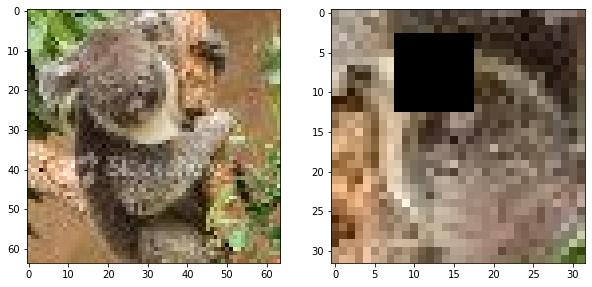

In [ ]:
# SAMPLE VISUALIZATION
visualize_before_after()

In [ ]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [ ]:
dataloader_handler = {
    "train": torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4),
    "val": torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
}

In [ ]:
train_loss = []
train_acc = []
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.train()
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
      for inputs, labels in train_dataloader:
        inputs = inputs['image'].to(device)
        labels = labels.to(device)
        outputs = model(inputs) # feed forward
        optimizer.zero_grad()
        acc = (outputs.argmax(1) == labels).float().mean() # accuracy(outputs, labels), compute accuracy
        loss = criterion(outputs, labels) # compute loss
        loss.backward()
        optimizer.step()
        prbar.set_description(
            "batch tloss: %.4f, batch tacc: %.4f" % (loss.item(), acc.item())
        ) 
        prbar.update(1)
        train_loss.append(loss.cpu().detach().item())
        train_acc.append(acc.cpu().detach().item())

@torch.no_grad()
def predict(model, val_dataloder, criterion, device="cuda:0"):
    model.to(device) # prevent errors when using single function outside training loop
    losses = []
    true_classes = np.array([])
    predicted_classes = np.array([])
    model.eval()
    with tqdm(total=len(val_dataloader), file=sys.stdout) as prbar:
        for inputs, labels in val_dataloader:
            inputs = inputs['image'].to(device)
            labels = labels.to(device)
            outputs = model(inputs) # feed forward
            loss = criterion(outputs, labels)
            acc = (outputs.argmax(1) == labels).float().mean()
            losses.append(loss.item())
            prbar.set_description(
                "batch vloss: %.4f, batch vacc: %.4f" % (loss.item(), acc.item())
            ) 
            prbar.update(1)
            true_classes = np.append(true_classes, labels.cpu().detach().numpy())
            predicted_classes = np.append(predicted_classes, outputs.argmax(1).cpu().detach().numpy())
    return np.array(losses), predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    e_loss = []
    e_acc = []
    for epoch in range(n_epochs):
        print("Epoch[%d] training..." % epoch)
        train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        losses, predicted_classes, true_classes = predict(model, val_dataloader, criterion, device)
        mean_loss = losses.mean()
        metrics = (mean_loss, (predicted_classes == true_classes).mean())
        if scheduler:
            scheduler.step(mean_loss)
        print("epoch loss: %.4f, epoch acc: %.4f" % (metrics[0], metrics[1]))
        # Train, evaluate, print accuracy, make a step of scheduler or whatever you want...
        e_loss.append(metrics[0])
        e_acc.append(metrics[1])
    return e_loss, e_acc


In [ ]:
import torchvision.models as models

### Часть, которую можно свернуть (заход на бонус)




In [ ]:
torch.manual_seed(42)

In [ ]:
class ModifiedResNet18(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = torch.nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False # use it instead of maxpool and change kernel size to lower 3x3 instead of 7x7
        )
        self.resnet.maxpool = torch.nn.Identity()
        self.resnet.fc = nn.Linear(512, 200)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [ ]:
resnet18 = ModifiedResNet18()

In [ ]:
model = resnet18 # THE MODEL THAT YOU CHOOSE
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4) # YOUR OPTIMIZER
train_dataloader = dataloader_handler['train'] # TRAIN DATALOADER WHICH YOU CONSTRUCT
val_dataloader = dataloader_handler['val'] # VAL DATALOADER WHICH YOU CONSTRUCT
criterion = nn.CrossEntropyLoss() # nn.CrossEntropyLoss() # LOSS THAT YOU OPTIMIZE (SHOLD BE CROSS ENTROPY OR SMTH ELSE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1) # LR SCHEDULE THAT YOU PROBABLY CHOOSE
n_epochs = 50 # NUMBER OF EPOCHS
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


Простой тест на проверку правильности написанного кода

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
print(len(predicted_labels), len(val_dataset))
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print(accuracy)
print("tests passed")

batch vloss: 7.3624, batch vacc: 0.0000: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
10000 10000
0.005
tests passed


Запустить обучение можно в ячейке ниже.

In [ ]:
train(resnet18, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Epoch[0] training...
batch vloss: 4.7218, batch vacc: 0.0551: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
epoch loss: 4.6201, epoch acc: 0.0515
Epoch[1] training...
batch vloss: 4.0304, batch vacc: 0.1250: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
epoch loss: 4.1185, epoch acc: 0.1271
Epoch[2] training...
batch vloss: 3.6259, batch vacc: 0.1618: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
epoch loss: 4.1132, epoch acc: 0.1197
Epoch[3] training...
batch vloss: 3.3528, batch vacc: 0.3162: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
epoch loss: 3.8028, epoch acc: 0.1628
Epoch[4] training...
batch vloss: 3.2909, batch vacc: 0.3125: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
epoch loss: 3.7269, epoch acc: 0.1827
Epoch[5] training...
batch vloss: 3.4360, batch vacc: 0.3235: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
epoch loss: 3.6221, epoch acc: 0.2058
Epoch[6] training...
batch vloss: 3.2864, batch vacc: 0.2537: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
ep

([4.620053815841675,
  4.118547737598419,
  4.1132360935211185,
  3.802778720855713,
  3.7269425868988035,
  3.6220829486846924,
  3.705846679210663,
  3.5791345953941347,
  3.5088521003723145,
  3.4667664408683776,
  3.3669970512390135,
  3.2922337532043455,
  3.266925942897797,
  3.265609693527222,
  3.2877191424369814,
  3.2515648722648622,
  3.170326018333435,
  3.1584096550941467,
  3.3323511242866517,
  3.254070246219635,
  2.6742778062820434,
  2.5938212633132935,
  2.560631000995636,
  2.503417432308197,
  2.4836806058883667,
  2.4709431409835814,
  2.4529536247253416,
  2.461648499965668,
  2.4048771500587462,
  2.427120441198349,
  2.3690937399864196,
  2.3981608152389526,
  2.3820932865142823,
  2.3575494647026063,
  2.3348562955856322,
  2.3472585439682008,
  2.2976770043373107,
  2.3228366494178774,
  2.3144198060035706,
  2.3244169116020204,
  2.194264602661133,
  2.1670078456401827,
  2.1542411923408507,
  2.1430228412151338,
  2.1386182367801667,
  2.131634521484375,
  

In [ ]:
# accuracy after 50 epochs
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
print(len(predicted_labels), len(val_dataset))
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print(accuracy)

batch vloss: 2.0426, batch vacc: 0.5515: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
10000 10000
0.5419


In [ ]:
# change number of epochs and hope for the best (total is 50 + 20 = 70)
n_epochs = 20
# change lr (previous was 0.05 at start of the training, but reduced to 0.0005 due to scheduler)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=5e-4) # YOUR OPTIMIZER
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,13], gamma=0.1) # LR SCHEDULE THAT YOU PROBABLY CHOOSE

In [ ]:
train(resnet18, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Epoch[0] training...
batch vloss: 2.0430, batch vacc: 0.5478: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
epoch loss: 2.1156, epoch acc: 0.5379
Epoch[1] training...
batch vloss: 2.0484, batch vacc: 0.5294: 100%|██████████| 20/20 [00:06<00:00,  2.87it/s]
epoch loss: 2.0947, epoch acc: 0.5425
Epoch[2] training...
batch vloss: 2.0353, batch vacc: 0.5515: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
epoch loss: 2.0927, epoch acc: 0.5420
Epoch[3] training...
batch vloss: 2.0191, batch vacc: 0.5478: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
epoch loss: 2.1038, epoch acc: 0.5435
Epoch[4] training...
batch vloss: 2.0046, batch vacc: 0.5662: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
epoch loss: 2.1012, epoch acc: 0.5409
Epoch[5] training...
batch vloss: 2.0071, batch vacc: 0.5699: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
epoch loss: 2.0868, epoch acc: 0.5456
Epoch[6] training...
batch vloss: 2.0073, batch vacc: 0.5478: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
ep

([2.115617793798447,
  2.094724100828171,
  2.092661589384079,
  2.1037700355052946,
  2.1012390494346618,
  2.086758667230606,
  2.0872295260429383,
  2.0906174004077913,
  2.08331583738327,
  2.091127133369446,
  2.078837013244629,
  2.071694868803024,
  2.076632869243622,
  2.0779599964618685,
  2.0797977685928344,
  2.064708250761032,
  2.0766901910305022,
  2.0807956755161285,
  2.070765030384064,
  2.0753883838653566],
 [0.5379,
  0.5425,
  0.542,
  0.5435,
  0.5409,
  0.5456,
  0.5469,
  0.5437,
  0.5456,
  0.5449,
  0.5464,
  0.5475,
  0.548,
  0.5443,
  0.5475,
  0.5466,
  0.549,
  0.545,
  0.5469,
  0.5467])

In [ ]:
# accuracy after 70 epochs
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
print(len(predicted_labels), len(val_dataset))
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print(accuracy)

batch vloss: 1.9636, batch vacc: 0.5735: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
10000 10000
0.5467


In [ ]:
# try to increase lr a bit and decrease again
# change number of epochs and hope for the best (total is 70 + 20 = 90)
n_epochs = 20
# change lr (previous was 0.000005 after all schedulers worked)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0008, momentum=0.9, weight_decay=5e-4) # YOUR OPTIMIZER
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,13], gamma=0.1) # LR SCHEDULE THAT YOU PROBABLY CHOOSE

In [ ]:
train(resnet18, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Epoch[0] training...
batch vloss: 2.0385, batch vacc: 0.5368: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
epoch loss: 2.0831, epoch acc: 0.5442
Epoch[1] training...
batch vloss: 2.0608, batch vacc: 0.5478: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
epoch loss: 2.0605, epoch acc: 0.5434
Epoch[2] training...
batch vloss: 1.9597, batch vacc: 0.5515: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
epoch loss: 2.0710, epoch acc: 0.5431
Epoch[3] training...
batch vloss: 1.9974, batch vacc: 0.5515: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
epoch loss: 2.0767, epoch acc: 0.5361
Epoch[4] training...
batch vloss: 2.0508, batch vacc: 0.5404: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
epoch loss: 2.0742, epoch acc: 0.5374
Epoch[5] training...
batch vloss: 2.0342, batch vacc: 0.5515: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
epoch loss: 2.0696, epoch acc: 0.5449
Epoch[6] training...
batch vloss: 2.0072, batch vacc: 0.5368: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
ep

([2.0831023156642914,
  2.060468065738678,
  2.071043002605438,
  2.0767474114894866,
  2.0742180585861205,
  2.0695657253265383,
  2.0428754687309265,
  2.0421570420265196,
  2.0502575814723967,
  2.0411776065826417,
  2.044291985034943,
  2.0338232576847077,
  2.051021361351013,
  2.043023157119751,
  2.041088891029358,
  2.0264786541461945,
  2.0273510575294496,
  2.0485211610794067,
  2.048312747478485,
  2.0349574625492095],
 [0.5442,
  0.5434,
  0.5431,
  0.5361,
  0.5374,
  0.5449,
  0.5472,
  0.5484,
  0.5477,
  0.5517,
  0.5499,
  0.5539,
  0.5504,
  0.5503,
  0.55,
  0.5526,
  0.5508,
  0.5499,
  0.5492,
  0.5551])

In [ ]:
# try hard once again (increase and decrease once)
# change number of epochs and hope for the best (total is 90 + 20 = 110)
n_epochs = 20
# change lr (previous was 0.000008)
optimizer = torch.optim.SGD(model.parameters(), lr=0.00008, momentum=0.9, weight_decay=5e-4) # YOUR OPTIMIZE
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1) # LR SCHEDULE THAT YOU PROBABLY CHOOSE

In [ ]:
train(resnet18, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Epoch[0] training...
batch vloss: 1.9858, batch vacc: 0.5404: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
epoch loss: 2.0383, epoch acc: 0.5531
Epoch[1] training...
batch vloss: 1.9726, batch vacc: 0.5625: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]
epoch loss: 2.0426, epoch acc: 0.5506
Epoch[2] training...
batch vloss: 1.9972, batch vacc: 0.5441: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
epoch loss: 2.0316, epoch acc: 0.5535
Epoch[3] training...
batch vloss: 1.9880, batch vacc: 0.5478: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
epoch loss: 2.0325, epoch acc: 0.5510
Epoch[4] training...
batch vloss: 2.0027, batch vacc: 0.5515: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
epoch loss: 2.0374, epoch acc: 0.5527
Epoch[5] training...
batch vloss: 1.9990, batch vacc: 0.5441: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
epoch loss: 2.0299, epoch acc: 0.5510
Epoch[6] training...
batch vloss: 1.9720, batch vacc: 0.5515: 100%|██████████| 20/20 [00:07<00:00,  2.86it/s]
ep

([2.038334387540817,
  2.042556118965149,
  2.0315613031387327,
  2.0325495421886446,
  2.037391424179077,
  2.0299007892608643,
  2.028788465261459,
  2.034645140171051,
  2.028744751214981,
  2.0380656480789185,
  2.035568428039551,
  2.036299777030945,
  2.028529042005539,
  2.0330076456069945,
  2.043207365274429,
  2.0271693766117096,
  2.03148358464241,
  2.029901909828186,
  2.0202405869960787,
  2.0247882902622223],
 [0.5531,
  0.5506,
  0.5535,
  0.551,
  0.5527,
  0.551,
  0.55,
  0.5504,
  0.5564,
  0.5515,
  0.5535,
  0.5503,
  0.5508,
  0.5511,
  0.5486,
  0.5544,
  0.5521,
  0.5499,
  0.5545,
  0.5528])

In [ ]:
# try hard once again (increase and decrease once)
# change number of epochs and hope for the best (total is 110 + 50 = 160)
n_epochs = 50
# change lr (previous was 0.000008)
optimizer = torch.optim.SGD(model.parameters(), lr=0.008, momentum=0.9, weight_decay=5e-4) # YOUR OPTIMIZE
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1) # LR SCHEDULE THAT YOU PROBABLY CHOOSE

In [ ]:
train(resnet18, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Epoch[0] training...
batch vloss: 2.3232, batch vacc: 0.4485: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
epoch loss: 2.4885, epoch acc: 0.4371
Epoch[1] training...
batch vloss: 2.2122, batch vacc: 0.5037: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
epoch loss: 2.4354, epoch acc: 0.4528
Epoch[2] training...
batch vloss: 2.3789, batch vacc: 0.4559: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
epoch loss: 2.3519, epoch acc: 0.4754
Epoch[3] training...
batch vloss: 2.4132, batch vacc: 0.4191: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
epoch loss: 2.3766, epoch acc: 0.4656
Epoch[4] training...
batch vloss: 2.1662, batch vacc: 0.5184: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
epoch loss: 2.3481, epoch acc: 0.4754
Epoch[5] training...
batch vloss: 2.4827, batch vacc: 0.4154: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
epoch loss: 2.3302, epoch acc: 0.4828
Epoch[6] training...
batch vloss: 2.1878, batch vacc: 0.5221: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
ep

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

__Ваш отчёт о проделанных экспериментах__: текст писать тут

### Часть с ответами

Возьмем очень глубокую Wide ResNet предобученную архитектуру.
Зафайнтюним последний линейный слой на 200 классов. И будем использовать autodiff только на последнем слое, чтобы не менять предобученные веса.
Будем использовать Adam с lr=3e-4, поскольку так говорит великий Andrej Karpathy: https://twitter.com/karpathy/status/801621764144971776?s=20

Также будет использовать планировщик, который будет уменьшать lr в зависимости от того, будет ли он на плато или нет. Использовать его не имеет особого смысла в данный момент, потому что сходимость наступает довольно быстро.

In [ ]:
wresnext101 = models.resnext101_32x8d(pretrained=True)

In [ ]:
wresnext101.fc = nn.Linear(2048, 200)

In [ ]:
model = wresnext101 # THE MODEL THAT YOU CHOOSE
for param in model.parameters():
  param.requires_grad = False 
for param in model.fc.parameters():
  param.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) # YOUR OPTIMIZER
train_dataloader = dataloader_handler['train'] # TRAIN DATALOADER WHICH YOU CONSTRUCT
val_dataloader = dataloader_handler['val'] # VAL DATALOADER WHICH YOU CONSTRUCT
criterion = nn.CrossEntropyLoss() # LOSS THAT YOU OPTIMIZE (SHOLD BE CROSS ENTROPY OR SMTH ELSE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min') # LR SCHEDULE THAT YOU PROBABLY CHOOSE
n_epochs = 1 # NUMBER OF EPOCHS
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Epoch[0] training...
batch vloss: 1.4088, batch vacc: 0.7500: 100%|██████████| 79/79 [00:40<00:00,  1.96it/s]
epoch loss: 1.7316, epoch acc: 0.6116


([1.7315988193584393], [0.6116])

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print(accuracy)
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))

batch vloss: 1.4088, batch vacc: 0.7500: 100%|██████████| 79/79 [00:40<00:00,  1.96it/s]
0.6116
Оценка за это задание составит 5 баллов


## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
# we will need this library to process the labeling
! pip install xmltodict

In [ ]:
import xmltodict, json

In [ ]:
!unzip /content/drive/My\ Drive/archive.zip 

Archive:  /content/drive/My Drive/archive.zip
  inflating: test_zip/test/apple_77.jpg  
  inflating: test_zip/test/apple_77.xml  
  inflating: test_zip/test/apple_78.jpg  
  inflating: test_zip/test/apple_78.xml  
  inflating: test_zip/test/apple_79.jpg  
  inflating: test_zip/test/apple_79.xml  
  inflating: test_zip/test/apple_80.jpg  
  inflating: test_zip/test/apple_80.xml  
  inflating: test_zip/test/apple_81.jpg  
  inflating: test_zip/test/apple_81.xml  
  inflating: test_zip/test/apple_82.jpg  
  inflating: test_zip/test/apple_82.xml  
  inflating: test_zip/test/apple_83.jpg  
  inflating: test_zip/test/apple_83.xml  
  inflating: test_zip/test/apple_84.jpg  
  inflating: test_zip/test/apple_84.xml  
  inflating: test_zip/test/apple_85.jpg  
  inflating: test_zip/test/apple_85.xml  
  inflating: test_zip/test/apple_86.jpg  
  inflating: test_zip/test/apple_86.xml  
  inflating: test_zip/test/apple_87.jpg  
  inflating: test_zip/test/apple_87.xml  
  inflating: test_zip/test/app

Датасет мы за вас написали.

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
# add any imports you need

class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

In [ ]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in train_dataloader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      loss_dict = model(images, targets)
      losses = sum(loss for loss in loss_dict.values())
      
      optimizer.zero_grad()
      losses.backward()
      optimizer.step()

      n += 1
      global_loss += float(losses.cpu().detach().numpy())

      if n % 10 == 0:
        print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

      
    
    return global_loss


def train(model, train_dataloader, val_dataloader, optimizer, scheduler=None, device="cpu", n_epochs=10):
    for epoch in range(n_epochs):
        a = evaluate(model, val_dataloader, device=device)
        print("AUC ON TEST: %.4f" % a)
        
        train_one_epoch(model, train_dataloader, optimizer, device=device)
        
        if scheduler is not None:
          scheduler.step()

In [ ]:
def get_detection_model(num_classes=2):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    
    return model

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_transform = A.Compose(
    [
      #A.CLAHE(),
      A.Flip(),
      #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
      #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
      A.RandomBrightnessContrast(p=0.2),
      #A.HueSaturationValue(),
      ToTensor()
    ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=['labels'])
)

val_transform = A.Compose(
    [
      ToTensor()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
)

# YOUR CODE FOR VALIDATION AUGMENTATIONS
# HINT: TRAIN TRANSFORM OBVIOUSLY SHOULD BE HARDER THAN THOSE FOR VALIDATION

train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./test_zip/test", transform=val_transform)

model = get_detection_model(4) # YOUR CODE, CREATE MODEL FOR OBJECT DETECTION
params = [p for p in model.parameters() if p.requires_grad]
# HINT: USE MATERIALS FROM THE SEMINAR
# YOU CAN USE torchvision.models AND torchvision.models.detection
# READ OFFICIAL DOCS FOR MORE INFO

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005, nesterov=True) # SELECT YOUR OPTIMIZER
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn) # CREATE YOUR DATALOADER, SELECT APPROPRIATE batch_size
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn) # CREATE VALIDATION DATALOADER
n_epochs = 10 # SELECT APPROPRIZTE NUMBER OF EPOCHS
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

train(model, train_dataloader, val_dataloader, optimizer, lr_scheduler, device, n_epochs)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.0088
Loss value after 10 batches is 0.8
Loss value after 20 batches is 0.55
Loss value after 30 batches is 0.46
Loss value after 40 batches is 0.44
Loss value after 50 batches is 0.43
Loss value after 60 batches is 0.41
Loss value after 70 batches is 0.39
Loss value after 80 batches is 0.37
Loss value after 90 batches is 0.36
Loss value after 100 batches is 0.34
Loss value after 110 batches is 0.33
Loss value after 120 batches is 0.32


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.8327
Loss value after 10 batches is 0.19
Loss value after 20 batches is 0.21
Loss value after 30 batches is 0.2
Loss value after 40 batches is 0.19
Loss value after 50 batches is 0.19
Loss value after 60 batches is 0.19
Loss value after 70 batches is 0.19
Loss value after 80 batches is 0.19
Loss value after 90 batches is 0.19
Loss value after 100 batches is 0.19
Loss value after 110 batches is 0.19
Loss value after 120 batches is 0.19


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.9012
Loss value after 10 batches is 0.14
Loss value after 20 batches is 0.17
Loss value after 30 batches is 0.19
Loss value after 40 batches is 0.18
Loss value after 50 batches is 0.19
Loss value after 60 batches is 0.18
Loss value after 70 batches is 0.18
Loss value after 80 batches is 0.18
Loss value after 90 batches is 0.18
Loss value after 100 batches is 0.18
Loss value after 110 batches is 0.18
Loss value after 120 batches is 0.17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.9222
Loss value after 10 batches is 0.19
Loss value after 20 batches is 0.17
Loss value after 30 batches is 0.16
Loss value after 40 batches is 0.17
Loss value after 50 batches is 0.16
Loss value after 60 batches is 0.16
Loss value after 70 batches is 0.15
Loss value after 80 batches is 0.15
Loss value after 90 batches is 0.15
Loss value after 100 batches is 0.15
Loss value after 110 batches is 0.15
Loss value after 120 batches is 0.14


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.9219
Loss value after 10 batches is 0.07
Loss value after 20 batches is 0.08
Loss value after 30 batches is 0.1
Loss value after 40 batches is 0.11
Loss value after 50 batches is 0.12
Loss value after 60 batches is 0.13
Loss value after 70 batches is 0.13
Loss value after 80 batches is 0.12
Loss value after 90 batches is 0.12
Loss value after 100 batches is 0.12
Loss value after 110 batches is 0.12
Loss value after 120 batches is 0.13


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.9375
Loss value after 10 batches is 0.14
Loss value after 20 batches is 0.13
Loss value after 30 batches is 0.12
Loss value after 40 batches is 0.12
Loss value after 50 batches is 0.12
Loss value after 60 batches is 0.12
Loss value after 70 batches is 0.12
Loss value after 80 batches is 0.13
Loss value after 90 batches is 0.13
Loss value after 100 batches is 0.13
Loss value after 110 batches is 0.12
Loss value after 120 batches is 0.13


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.9425
Loss value after 10 batches is 0.11
Loss value after 20 batches is 0.12
Loss value after 30 batches is 0.12
Loss value after 40 batches is 0.12
Loss value after 50 batches is 0.11
Loss value after 60 batches is 0.12
Loss value after 70 batches is 0.12
Loss value after 80 batches is 0.12
Loss value after 90 batches is 0.12
Loss value after 100 batches is 0.12
Loss value after 110 batches is 0.12
Loss value after 120 batches is 0.12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.9388
Loss value after 10 batches is 0.08
Loss value after 20 batches is 0.1
Loss value after 30 batches is 0.12
Loss value after 40 batches is 0.12
Loss value after 50 batches is 0.11
Loss value after 60 batches is 0.11
Loss value after 70 batches is 0.11
Loss value after 80 batches is 0.11
Loss value after 90 batches is 0.11
Loss value after 100 batches is 0.11
Loss value after 110 batches is 0.12
Loss value after 120 batches is 0.12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.9407
Loss value after 10 batches is 0.08
Loss value after 20 batches is 0.12
Loss value after 30 batches is 0.14
Loss value after 40 batches is 0.14
Loss value after 50 batches is 0.13
Loss value after 60 batches is 0.13
Loss value after 70 batches is 0.13
Loss value after 80 batches is 0.12
Loss value after 90 batches is 0.12
Loss value after 100 batches is 0.12
Loss value after 110 batches is 0.12
Loss value after 120 batches is 0.12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.9417
Loss value after 10 batches is 0.14
Loss value after 20 batches is 0.12
Loss value after 30 batches is 0.12
Loss value after 40 batches is 0.12
Loss value after 50 batches is 0.11
Loss value after 60 batches is 0.11
Loss value after 70 batches is 0.11
Loss value after 80 batches is 0.12
Loss value after 90 batches is 0.12
Loss value after 100 batches is 0.12
Loss value after 110 batches is 0.12
Loss value after 120 batches is 0.12


__Выведите итоговое качество модели__.

In [ ]:
auc_res = evaluate(model, val_dataloader, device=device)
print("AUC: %.4f" % auc_res)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc_res / 0.91)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC: 0.9416
Оценка за это задание составит 4 баллов


Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [ ]:
image, labels = next(iter(train_dataset))
pred = model(image.unsqueeze(0).to(device))[0]

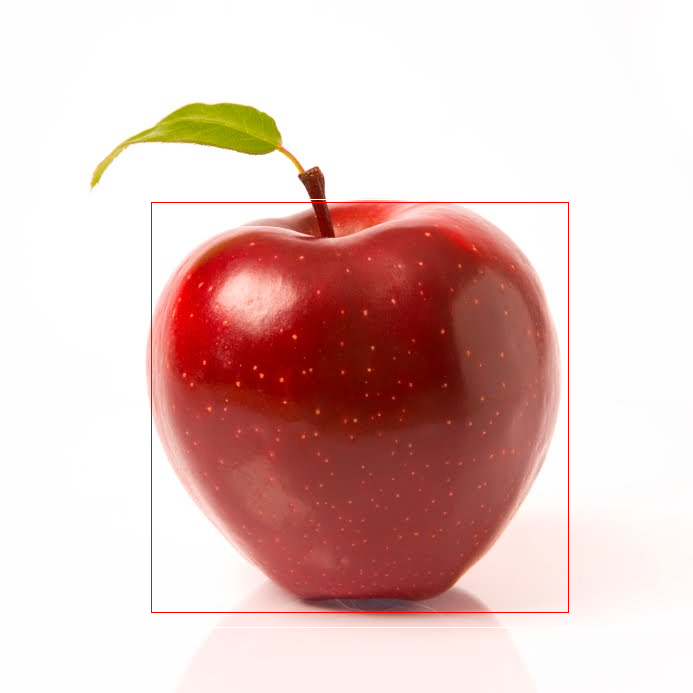

In [ ]:
from PIL import ImageDraw

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь accuracy не менее 0.52. Напишите отчёт о проделанных экспериментах.

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы преодолели качество 0.52 и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

In [ ]:
# YOUR CODE

## Бонус (0 баллов).

__Задание 1__. Скиньте ниже смешную картинку, желательно про машинное обучение. На картинке не должно быть никаких упоминаний лектора, семинаристов и ассистентов этого курса.

__Задание 2__. Расскажите, как вам задание? Что понравилось, что не понравилось, что можно улучшить? Мы примем во внимание любой фидбек.